In [122]:
import sys
!{sys.executable} -m pip install tensorflow==1.13rc0


     |████████████████████████████████| 71.6MB 2.4MB/s eta 0:00:011     |███████████████████████████▋    | 61.9MB 7.6MB/s eta 0:00:02��██████| 71.4MB 2.4MB/s eta 0:00:01
     |████████████████████████████████| 3.1MB 32.4MB/s eta 0:00:01
  Found existing installation: tensorboard 2.0.1
    Uninstalling tensorboard-2.0.1:
      Successfully uninstalled tensorboard-2.0.1
  Found existing installation: tensorflow 1.13.1
    Uninstalling tensorflow-1.13.1:
      Successfully uninstalled tensorflow-1.13.1


In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
import tensorflow as tf
print(tf.__version__)

1.13.0-rc0


In [57]:
# Importing packages
import io
from pathlib import Path
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib as mpl
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, GRU
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import model_from_json
import glob
import missingno as msno
from datetime import datetime, timedelta
from scipy import stats
from itertools import product
from math import sqrt
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
sns.set()
import os

In [3]:
def load_dataset():

    path =r'./' # use your path
    allFiles = glob.glob(path + "/*.csv")
    frame = pd.DataFrame()
    list_ = []
    for file_ in allFiles:
        df = pd.read_csv(file_,index_col=None, header=0)
        list_.append(df)
    frame = pd.concat(list_)

    cols = ['date', 'station', 'BEN', 'CH4', 'CO', 'EBE', 'MXY', 'NMHC', 'NO', 'NO_2', 'NOx', 'OXY',
           'O_3', 'PM10', 'PM25', 'PXY', 'SO_2', 'TCH', 'TOL']
    frame = frame[cols]
    # frame = frame.sort_values(['station', 'date'])
    
    cut_frame = frame.copy()
    # cut_frame = frame[frame['station'] == int(28079055)].filter(['date', 'CO', 'NO_2', 'O_3', 'PM10', 'SO_2'], axis=1) # best station number is 28079099
    cut_frame = frame.filter(['date', 'CO', 'NO_2', 'O_3', 'PM10', 'SO_2'], axis=1) # best station number is 28079099

    # print("Size of cut_frame: " , cut_frame.size)

    # station_ids = cut_frame.station.unique()
    # 28079099 only has data up to Jan 2012

    return cut_frame

def analyze_per_station(station_number, frame):
    frame_station = frame[frame['station'] == station_number]
    print("Station: ", station_number, "  -  Len cut_frame: ", len(frame_station))
    missing_data(station_number, frame_station)
    return frame_station


def missing_data(station_number, frame):
    msno.matrix(frame)
    # fig = plt.figure()
    plt.title('Station Number: %i' % station_number)
    plt.show()

    # plt.draw()
    # fig.savefig("Missing_Values.png")
    plt.clf()
    msno.bar(frame)
    plt.title("Station Number: %i" % station_number)
    plt.show()
    # plt.draw()


def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)


In [6]:
print("### Loading dataset...")
frame = load_dataset()

frame['date'] = pd.to_datetime(frame.date, errors='coerce')
frame.set_index('date', drop=False, inplace=True)

#Take the average of each month
frame['daily'] = frame['date'].apply(lambda x: x.strftime('%Y-%m-%d')) 
frame = frame.groupby('daily').mean()

frame = frame.reset_index()
frame.daily = pd.to_datetime(frame.daily, errors='coerce')
print(frame.tail(20))

### Loading dataset...
          daily        CO       NO_2        O_3       PM10      SO_2
6310 2018-04-12  0.268936  29.396161  63.277108   8.058632  4.708861
6311 2018-04-13  0.268220  31.012153  67.913174   7.974359  4.420833
6312 2018-04-14  0.325833  36.475694  47.423881  10.179487  5.575000
6313 2018-04-15  0.246444  21.696181  50.281437   9.871795  4.711297
6314 2018-04-16  0.318987  22.019097  70.349254   8.482759  4.588235
6315 2018-04-17  0.394828  46.743860  39.699088  15.968421  5.184549
6316 2018-04-18  0.365403  49.763206  46.457792  16.711268  4.426540
6317 2018-04-19  0.273423  32.041293  71.069182  27.092466  4.108597
6318 2018-04-20  0.260426  24.837128  75.358896  40.284314  3.891213
6319 2018-04-21  0.266250  25.100694  63.080357  40.445513  4.175000
6320 2018-04-22  0.301667  33.190972  50.464286  35.868590  4.420833
6321 2018-04-23  0.331250  42.808362  38.138554  33.470968  5.004184
6322 2018-04-24  0.311814  39.146597  45.824773  35.487097  4.300847
6323 2018-0

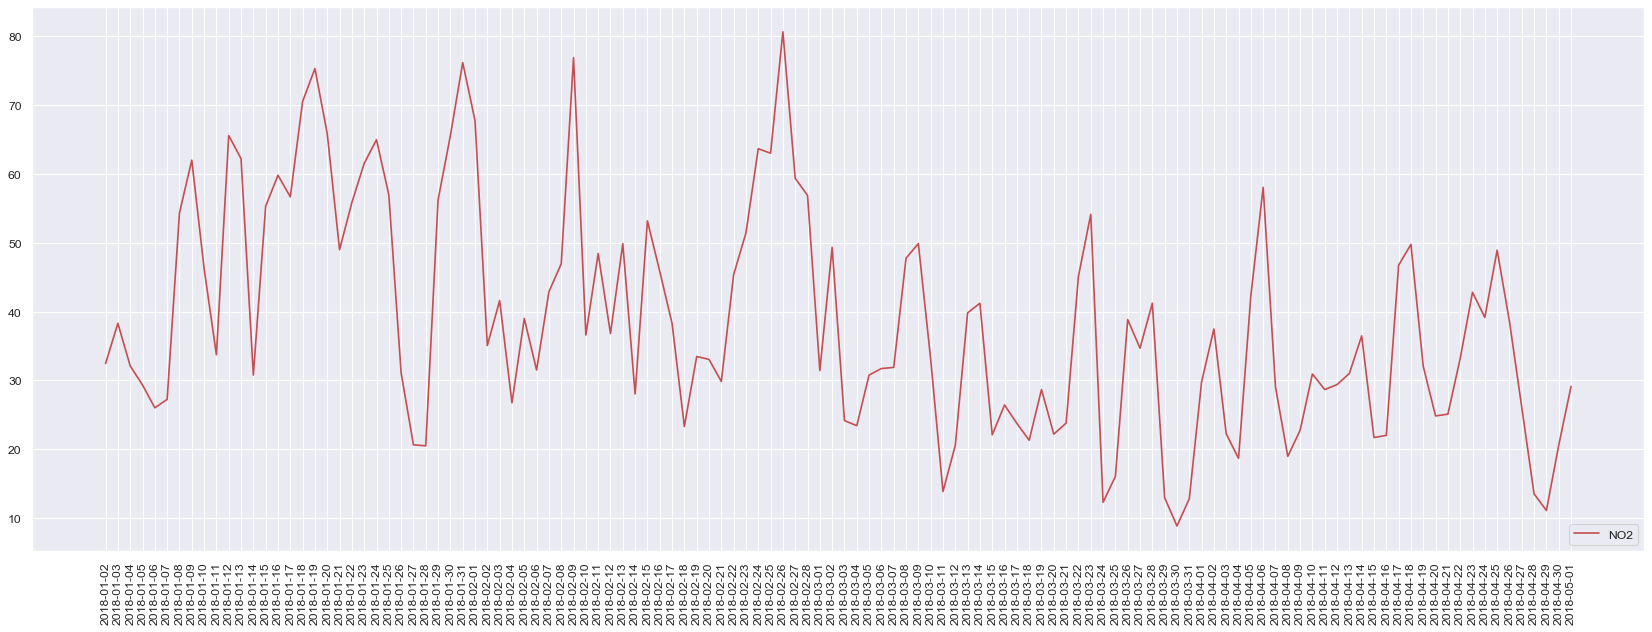

In [51]:
df1 = frame.reset_index() #df1 will have a numeric index, and a 
                        #column named 'index' containing the index labels from frame
df2 = df1[-120:]    
plt.figure(figsize=(26, 9))
#plt.scatter(df1.index[1:1000],df1['CO'][1:1000],c='b',label='CO')
plt.plot(df2.index,df2['NO_2'],c='r',label='NO2')
plt.legend(loc=4) # Optional - show labelled legend, loc=4 puts it at bottom right
plt.xticks(df2.index,df2['daily'], rotation='vertical') # explicitly set one tick per category and label them
                                   # according to the labels in column df1['index']
plt.show()

# ax = sns.scatterplot(x=frame['date'], y=frame['CO'])

In [54]:
#Take the average of each month
frame['monthly'] = frame['date'].apply(lambda x: x.strftime('%Y-%m')) 
# Group data by month
# print(frame.index)
print(frame.keys())

frame = frame.groupby('monthly').mean()

# monthly_mean['YearMonth'] = frame.apply(lambda x: '{year}-{month}'.format(year=frame.index.year, month=frame.index.month))
# frame.reset_index()
# monthly_mean = monthly_mean.groupby('YearMonth').mean()
print(frame.tail(30))

Index(['date', 'CO', 'NO_2', 'O_3', 'PM10', 'SO_2', 'monthly'], dtype='object')
               CO       NO_2        O_3       PM10       SO_2
monthly                                                      
2015-12  0.605213  64.670393  14.492475  32.119307  11.119051
2016-01  0.402136  42.037366  30.615607  14.621770   8.790133
2016-02  0.372421  35.593962  43.005758  21.241612   8.457750
2016-03  0.352687  36.197951  52.581159  13.734664   8.548169
2016-04  0.307124  32.385142  54.070477  10.629888   7.742030
2016-05  0.285389  30.861185  60.953516  12.936964   7.262209
2016-06  0.259571  30.073953  66.729225  21.146051   7.947080
2016-07  0.250433  30.925501  78.616371  25.675509   5.792392
2016-08  0.251945  28.575672  71.293540  24.488569   5.922558
2016-09  0.319324  43.389988  52.129087  23.702078   6.873690
2016-10  0.415984  49.100528  32.515237  23.855654   7.464534
2016-11  0.485607  48.889412  24.215452  17.900230   7.858485
2016-12  0.597765  55.686849  18.782227  20.079104  

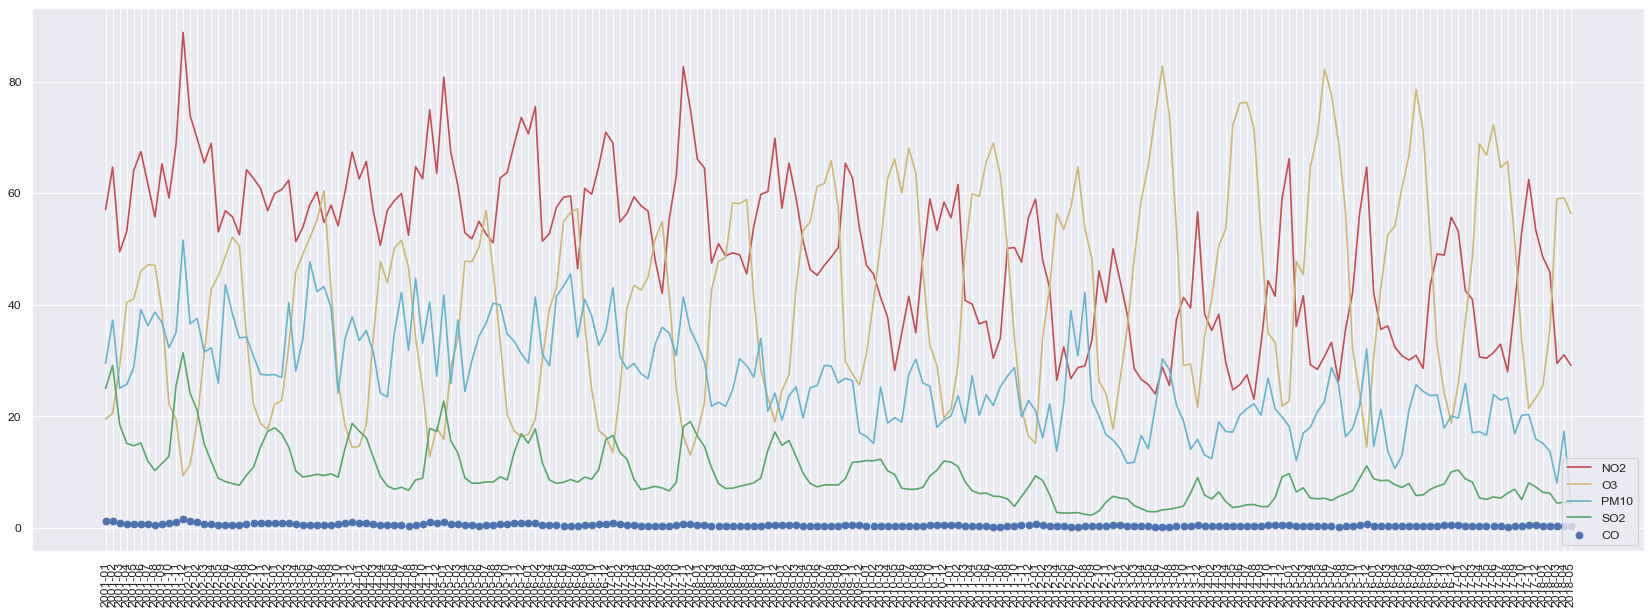

In [56]:
df1 = frame.reset_index() #df1 will have a numeric index, and a 
                        #column named 'index' containing the index labels from frame  
plt.figure(figsize=(26, 9))
plt.scatter(df1.index,df1['CO'],c='b',label='CO')
plt.plot(df1.index,df1['NO_2'],c='r',label='NO2')
plt.plot(df1.index,df1['O_3'],c='y',label='O3')
plt.plot(df1.index,df1['PM10'],c='c',label='PM10')
plt.plot(df1.index,df1['SO_2'],c='g',label='SO2')
plt.legend(loc=4) # Optional - show labelled legend, loc=4 puts it at bottom right
plt.xticks(df1.index,df1['monthly'], rotation='vertical') # explicitly set one tick per category and label them
                                   # according to the labels in column df1['index']
plt.show()

In [45]:
#Take the max of each year
frame['max_per_year'] = frame['date'].apply(lambda x: x.strftime('%Y')) 
# Group data by month
# print(frame.index)
print(frame.keys())

frame = frame.groupby('max_per_year').mean()
print(frame.head(30))

df1 = frame.reset_index() #df1 will have a numeric index, and a 
                        #column named 'index' containing the index labels from frame  
plt.figure(figsize=(26, 9))
plt.scatter(df1.index,df1['CO'],c='b',label='CO')
plt.plot(df1.index,df1['NO_2'],c='r',label='NO2')
plt.plot(df1.index,df1['O_3'],c='y',label='O3')
plt.plot(df1.index,df1['PM10'],c='c',label='PM10')
plt.plot(df1.index,df1['SO_2'],c='g',label='SO2')
plt.legend(loc=4) # Optional - show labelled legend, loc=4 puts it at bottom right
plt.xticks(df1.index,df1['max_per_year'], rotation='vertical') # explicitly set one tick per category and label them
                                   # according to the labels in column df1['index']
plt.show()

Index(['date', 'CO', 'NO_2', 'O_3', 'PM10', 'SO_2', 'max_per_year'], dtype='object')
                    CO       NO_2        O_3       PM10       SO_2
max_per_year                                                      
2001          1.418791  61.641023  39.537116  32.548376  26.843520
2002          1.214905  57.996663  37.373351  32.579835  16.523529
2003          0.773875  42.824159  43.018354  35.083724  17.061349
2004          0.676905  59.817395  37.326737  47.083743  15.120946
2005          0.672469  73.226078  35.590761  39.150272  14.261826
2006          0.724248  69.534461  37.497759  43.571681  13.583090
2007          0.511184  64.764567  37.990359  36.156922  12.674012
2008          0.349847  55.634366  44.374759  29.402331  13.268553
2009          0.335286  49.433556  50.422131  29.244799  11.023707
2010               NaN  54.023135        NaN  26.263913  10.958576
2011               NaN  55.140993        NaN  28.218676   6.202448
2012               NaN  43.561304        NaN

In [7]:
##Data Preparation
frame = frame.reset_index()

frame.head(5)

,index,daily,CO,NO_2,O_3,PM10,SO_2
0,0,2001-01-01,0.998400,47.760278,22.275357,19.367887,18.896400
1,1,2001-01-02,0.713709,45.141650,36.652239,17.426450,16.859624
2,2,2001-01-03,0.871186,53.401426,23.558798,24.811873,18.297260
3,3,2001-01-04,0.848846,50.055048,25.265474,25.086376,17.920690
4,4,2001-01-05,1.197067,51.629295,11.781987,26.796617,18.446490


In [8]:
#Data Split

df_train = frame[frame['daily'].dt.year < 2015]
df_test = frame[(frame['daily'].dt.year >= 2015) & (frame['daily'].dt.year <2018)]
print("Train: ", df_train.count())
# df_train.head()
print("Test: ", df_test.count())
df_test.head()



Train:  index    5113
daily    5113
CO       5113
NO_2     5113
O_3      5113
PM10     5113
SO_2     5113
dtype: int64
Test:  index    1096
daily    1096
CO       1096
NO_2     1096
O_3      1096
PM10     1096
SO_2     1096
dtype: int64


,index,daily,CO,NO_2,O_3,PM10,SO_2
5113,5113,2015-01-01,0.940000,95.772569,10.553571,37.280142,14.316667
5114,5114,2015-01-02,0.936667,100.647569,7.348214,27.761404,15.025000
5115,5115,2015-01-03,0.862917,90.723958,8.047619,24.209386,13.737500
5116,5116,2015-01-04,0.945833,91.850694,10.982090,21.708333,14.420833
5117,5117,2015-01-05,0.802586,83.609842,10.006079,22.763251,12.317597


In [24]:
df_train = df_train.drop(['daily'],axis=1)
df_test = df_test.drop(['daily'],axis=1)
# To be able to apply the scaler

KeyError: "['daily'] not found in axis"

In [10]:
scaler = MinMaxScaler()
df_train = scaler.fit_transform(df_train)
df_test = scaler.transform(df_test)
df_train = pd.DataFrame(df_train)
df_train.index = pd.date_range(start = "2001-01-01",periods=len(df_train),freq = 'D')
df_test = pd.DataFrame(df_test)
df_test.index = pd.date_range(start = "2015-01-01",periods=len(df_test),freq = 'D')



In [17]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        endx = i + n_steps
        if endx > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences.values[i:endx, :], sequences.values[endx, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [67]:
# VARs for Comet

window_size = 6
batch_size = 32
shuffle_buffer_size = 360
num_epochs = 60

In [68]:
x_train,y_train = split_sequences(df_train,window_size)
x_test,y_test = split_sequences(df_test,window_size)


In [66]:
# Simple RNN
x_train.shape

(5107, 6, 6)

In [70]:
#LSTM

model = Sequential()
model.add(LSTM(units = 16, input_shape = (x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(window_size))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = model.fit(x_train, y_train,validation_data=(x_test,y_test), epochs = num_epochs, 
                    steps_per_epoch=32, validation_steps=3)

Epoch 1/60
32/32 [==============================] - 3s 90ms/step - loss: 0.0606 - val_loss: 0.0701
Epoch 2/60
32/32 [==============================] - 2s 47ms/step - loss: 0.0318 - val_loss: 0.0408
Epoch 3/60
32/32 [==============================] - 2s 59ms/step - loss: 0.0226 - val_loss: 0.0192
Epoch 4/60
32/32 [==============================] - 2s 72ms/step - loss: 0.0177 - val_loss: 0.0122
Epoch 5/60
32/32 [==============================] - 2s 63ms/step - loss: 0.0154 - val_loss: 0.0102
Epoch 6/60
32/32 [==============================] - 2s 75ms/step - loss: 0.0139 - val_loss: 0.0089
Epoch 7/60
32/32 [==============================] - 2s 60ms/step - loss: 0.0128 - val_loss: 0.0081
Epoch 8/60
32/32 [==============================] - 2s 55ms/step - loss: 0.0121 - val_loss: 0.0077
Epoch 9/60
32/32 [==============================] - 2s 52ms/step - loss: 0.0115 - val_loss: 0.0073
Epoch 10/60
32/32 [==============================] - 2s 58ms/step - loss: 0.0110 - val_loss: 0.0071
Epoch 11/

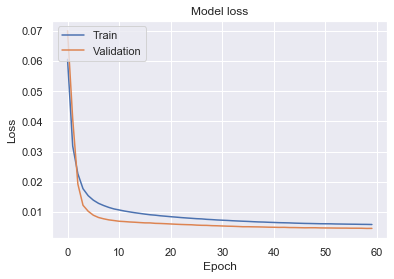

In [72]:
##Model loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [74]:
#Measuring performance

predictions = model.predict(x_test)

predictions.mean()



ValueError: Error when checking input: expected lambda_input to have 2 dimensions, but got array with shape (1090, 6, 6)

In [50]:
y_test.mean()

0.34237741028003293

In [65]:
# tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

tf.keras.backend.clear_session()
# tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss='mean_squared_error',
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=num_epochs, 
                    validation_data=(x_test,y_test), steps_per_epoch=32, validation_steps=3,
                    callbacks=[lr_schedule])

NameError: name 'x_valid' is not defined